### **Unggah kaggle.json dan Konfigurasi API**

In [1]:
from google.colab import files
files.upload()  # Unggah file kaggle.json

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"siwiyulindaa","key":"ad78ca7a19317ebd2f03ea7fd99677ba"}'}

In [2]:
# Membuat direktori .kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dataset dari Kaggle
!kaggle datasets download -d syedalinaqvi/augmented-skin-conditions-image-dataset -p /content/dataset

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset
License(s): CC-BY-SA-4.0
100% 272M/273M [00:15<00:00, 20.5MB/s]
100% 273M/273M [00:15<00:00, 18.7MB/s]


### **Ekstraksi Dataset**

In [3]:
# Ekstraksi dataset
import zipfile
with zipfile.ZipFile('/content/dataset/augmented-skin-conditions-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


### **Import Library**

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

### **Load Dataset**

In [5]:
from google.colab import files
import pandas as pd

# Unggah file secara langsung
uploaded = files.upload()

# Memastikan file berhasil diunggah
skin_descript_path = list(uploaded.keys())[0]  # Mengambil nama file yang diunggah
print(f"File yang diunggah: {skin_descript_path}")

# Membaca file CSV dengan encoding yang sesuai
try:
    skin_descript = pd.read_csv(skin_descript_path, encoding='utf-8')
except UnicodeDecodeError:
    skin_descript = pd.read_csv(skin_descript_path, encoding='latin1')  # Gunakan encoding alternatif

# Pastikan dataset deskripsi memiliki kolom yang benar
print(skin_descript.head())

# Membuat dictionary untuk deskripsi penyakit
disease_info = {
    row['kondisi']: {
        "penjelasan": row['penjelasan '],
        "penyebab": row['penyebab '],
        "pengobatan": row['pengobatan'],
        "pencegahan": row['cara pencegahan']
    }
    for _, row in skin_descript.iterrows()
}



Saving skin_description.csv to skin_description.csv
File yang diunggah: skin_description.csv
     kondisi                                        penjelasan   \
0       Acne  Acne atau jerawat adalah kondisi kulit yang um...   
1  Carcinoma  Carcinoma adalah jenis kanker yang berkembang ...   
2     Eczema  Eksim adalah istilah terkait gangguan pembengk...   
3  Keratosis  Keratosis adalah pertumbuhan kulit non-kanker ...   
4      Milia  Milia adalah kista yang termasuk dalam kista e...   

                                           penyebab   \
0  Produksi sebum berlebih, yaitu zat yang merupa...   
1  Penyebab pasti karsinoma bervariasi, tetapi be...   
2  Eksim dapat disebabkan oleh faktor dari luar (...   
3  Riwayat keluarga\nSebagian orang yang terkena ...   
4  Lepuhan pada kulit yang terjadi karena berbaga...   

                                          pengobatan  \
0  Beberapa langkah bisa kamu lakukan sebagai car...   
1  Kemoterapi, yaitu terapi untuk membunuh sel ka...   

In [6]:
dataset_path = '/content/dataset/Skin_Conditions'

dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    shuffle=True
)

Found 2394 files belonging to 6 classes.


In [7]:
# Pastikan variabel `skin_descript_path` berisi nama file yang diunggah
print(f"Memuat file dari path: {skin_descript_path}")

# Cobalah membaca file dengan encoding 'utf-8' atau 'latin1' jika terjadi kesalahan
try:
    skin_descript = pd.read_csv(skin_descript_path, encoding='utf-8')
except UnicodeDecodeError:
    skin_descript = pd.read_csv(skin_descript_path, encoding='latin1')

print("Dataset skin_description berhasil dimuat:")
print(skin_descript.head())

Memuat file dari path: skin_description.csv
Dataset skin_description berhasil dimuat:
     kondisi                                        penjelasan   \
0       Acne  Acne atau jerawat adalah kondisi kulit yang um...   
1  Carcinoma  Carcinoma adalah jenis kanker yang berkembang ...   
2     Eczema  Eksim adalah istilah terkait gangguan pembengk...   
3  Keratosis  Keratosis adalah pertumbuhan kulit non-kanker ...   
4      Milia  Milia adalah kista yang termasuk dalam kista e...   

                                           penyebab   \
0  Produksi sebum berlebih, yaitu zat yang merupa...   
1  Penyebab pasti karsinoma bervariasi, tetapi be...   
2  Eksim dapat disebabkan oleh faktor dari luar (...   
3  Riwayat keluarga\nSebagian orang yang terkena ...   
4  Lepuhan pada kulit yang terjadi karena berbaga...   

                                          pengobatan  \
0  Beberapa langkah bisa kamu lakukan sebagai car...   
1  Kemoterapi, yaitu terapi untuk membunuh sel ka...   
2  Pen

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Fungsi untuk memotong teks jika terlalu panjang
def truncate_text(text, max_length=100):
    """Memotong teks yang terlalu panjang"""
    return text if len(text) <= max_length else text[:max_length] + "..."

# Fungsi plotting yang sudah diperbarui
def plot_random_images_with_full_info(dataset, model, class_names, disease_info, num_images=9):
    """Menampilkan gambar dengan informasi lengkap tentang penyakit"""
    plt.figure(figsize=(15, 15))

    # Pilih gambar secara acak dari dataset
    indices = np.random.choice(len(dataset), size=num_images, replace=False)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]  # Dataset harus berisi pasangan gambar dan label
        img = img.numpy()  # Jika menggunakan PyTorch, pastikan gambar dalam format numpy
        predicted_class = model.predict(img)  # Misalnya, model prediksi di sini
        predicted_class_name = class_names[predicted_class]
        true_class_name = class_names[label]

        # Ambil deskripsi penyakit dari dictionary berdasarkan prediksi atau label
        description = disease_info.get(predicted_class_name, {})

        # Menampilkan gambar
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.astype("uint8"))
        plt.axis("off")
        plt.title(f"Pred: {predicted_class_name}\nTrue: {true_class_name}", fontsize=10)

        # Menambahkan teks deskripsi di luar gambar dengan posisi scrollable
        plt.figtext(0.5, 0.01 - (i * 0.1),  # Posisi teks
                    f"Penjelasan: {truncate_text(description.get('penjelasan', 'N/A'))}\n"
                    f"Penyebab: {truncate_text(description.get('penyebab', 'N/A'))}\n"
                    f"Pengobatan: {truncate_text(description.get('pengobatan', 'N/A'))}\n"
                    f"Pencegahan: {truncate_text(description.get('pencegahan', 'N/A'))}",
                    wrap=True, horizontalalignment='center', fontsize=8)

    plt.tight_layout()  # Atur layout supaya tidak tumpang tindih
    plt.show()



### **Split Dataset**

In [9]:
# Split dataset
def split_dataset(dataset, train_size=0.8, val_size=0.1):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_count = int(train_size * dataset_size)
    val_count = int(val_size * dataset_size)
    train_dataset = dataset.take(train_count)
    val_dataset = dataset.skip(train_count).take(val_count)
    test_dataset = dataset.skip(train_count + val_count)
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

### **Preprocessing**

In [10]:
# Augmentasi data (tanpa layer instan)
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomTranslation(0.2, 0.2),
    RandomContrast(0.2)
])

In [11]:
# Normalisasi data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [12]:
# Prefetch untuk performa lebih baik
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### **Model**

In [13]:
# Model Custom CNN
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

class CustomCNN(Model):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2))

        self.conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPooling2D((2, 2))

        self.conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.bn3 = BatchNormalization()
        self.pool3 = MaxPooling2D((2, 2))

        self.flatten = Flatten()
        self.fc1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.5)
        self.fc2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        return self.fc2(x)

### **Compile, Train, dan Evaluasi Model**

In [14]:
# Inisialisasi model
num_classes = len(dataset.class_names)
model = CustomCNN(num_classes)

In [15]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('custom_cnn_best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [17]:
# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.2112 - loss: 3.1993 - val_accuracy: 0.2455 - val_loss: 1.9107 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - accuracy: 0.3370 - loss: 1.8759 - val_accuracy: 0.4062 - val_loss: 1.7428 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.4452 - loss: 1.7269 - val_accuracy: 0.5312 - val_loss: 1.5797 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - accuracy: 0.4900 - loss: 1.6088 - val_accuracy: 0.5804 - val_loss: 1.4011 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 0.5949 - loss: 1.3878 - val_accuracy: 0.5268 - val_loss: 1.4501 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.5708 - loss: 1.3959 - val_accuracy: 0.6161 - val_loss: 1.3324 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.6528 - loss: 1.

In [18]:
# Evaluasi pada test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - accuracy: 0.8253 - loss: 1.0478
Test Accuracy: 0.86


### **Visualisasi Hasil**

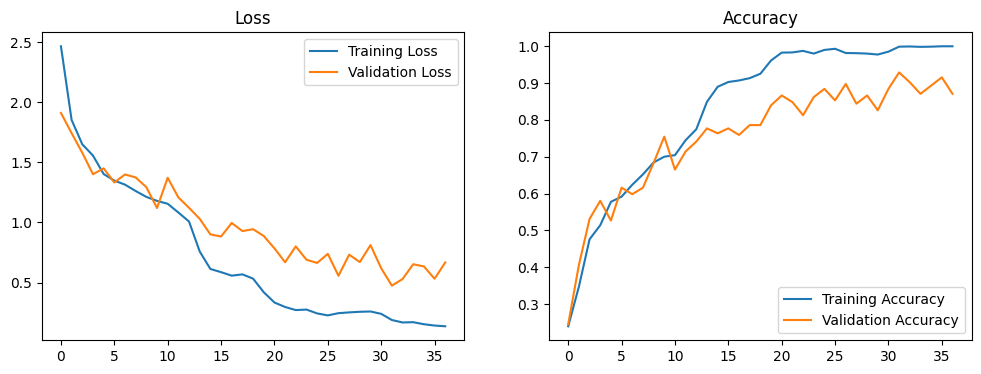

In [19]:
# Plot hasil training
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

plot_training_history(history)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import textwrap

def plot_random_images_with_full_info(test_dataset, model, class_names, disease_info, num_images=9):
    # Tentukan jumlah baris dan kolom untuk grid subplot
    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(20, 35))  # Perbesar figure
    axes = axes.flatten()

    # Ambil batch gambar dan label dari dataset
    for image_batch, label_batch in test_dataset.take(1):
        predictions = model.predict(image_batch)
        predicted_labels = tf.argmax(predictions, axis=1).numpy()
        indices = np.random.choice(len(image_batch), num_images, replace=False)

        for idx, ax in enumerate(axes):
            # Ambil gambar dan label berdasarkan indeks acak
            img = (image_batch[indices[idx]].numpy() * 255).astype(np.uint8)
            true_label = label_batch[indices[idx]].numpy()
            pred_label = predicted_labels[indices[idx]]

            # Tampilkan gambar
            ax.imshow(img)
            ax.axis('off')

            # Ambil nama label sebenarnya dan prediksi
            true_label_name = class_names[true_label]
            pred_label_name = class_names[pred_label]
            title_color = 'green' if true_label == pred_label else 'red'

            # Ambil informasi dari dictionary disease_info
            info = disease_info.get(pred_label_name, {
                "penjelasan": "Tidak ada deskripsi.",
                "penyebab": "Tidak ada data.",
                "pengobatan": "Tidak ada data.",
                "pencegahan": "Tidak ada data."
            })

            # Format teks penjelasan agar lebih rapi
            description = (
                f"Penjelasan: {info['penjelasan']}\n"
                f"Penyebab: {info['penyebab']}\n"
                f"Pengobatan: {info['pengobatan']}\n"
                f"Pencegahan: {info['pencegahan']}"
            )
            wrapped_text = "\n".join(textwrap.wrap(description, width=50))  # Batasi lebar teks

            # Set judul prediksi dan label aktual di atas gambar
            ax.set_title(
                f"Prediksi: {pred_label_name}\nActual: {true_label_name}",
                color=title_color, fontsize=14, loc='center'
            )

            # Posisi teks deskripsi di bawah gambar
            ax.text(
                0.5, -0.2, wrapped_text,  # Lebih jauh ke bawah agar tidak tertumpuk
                transform=ax.transAxes,
                fontsize=10,
                color='black',
                ha='center',
                va='top',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8)
            )

    # Atur tata letak subplot
    plt.subplots_adjust(hspace=5.5, wspace=0.5)  # Menambahkan lebih banyak ruang antar baris dan kolom
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


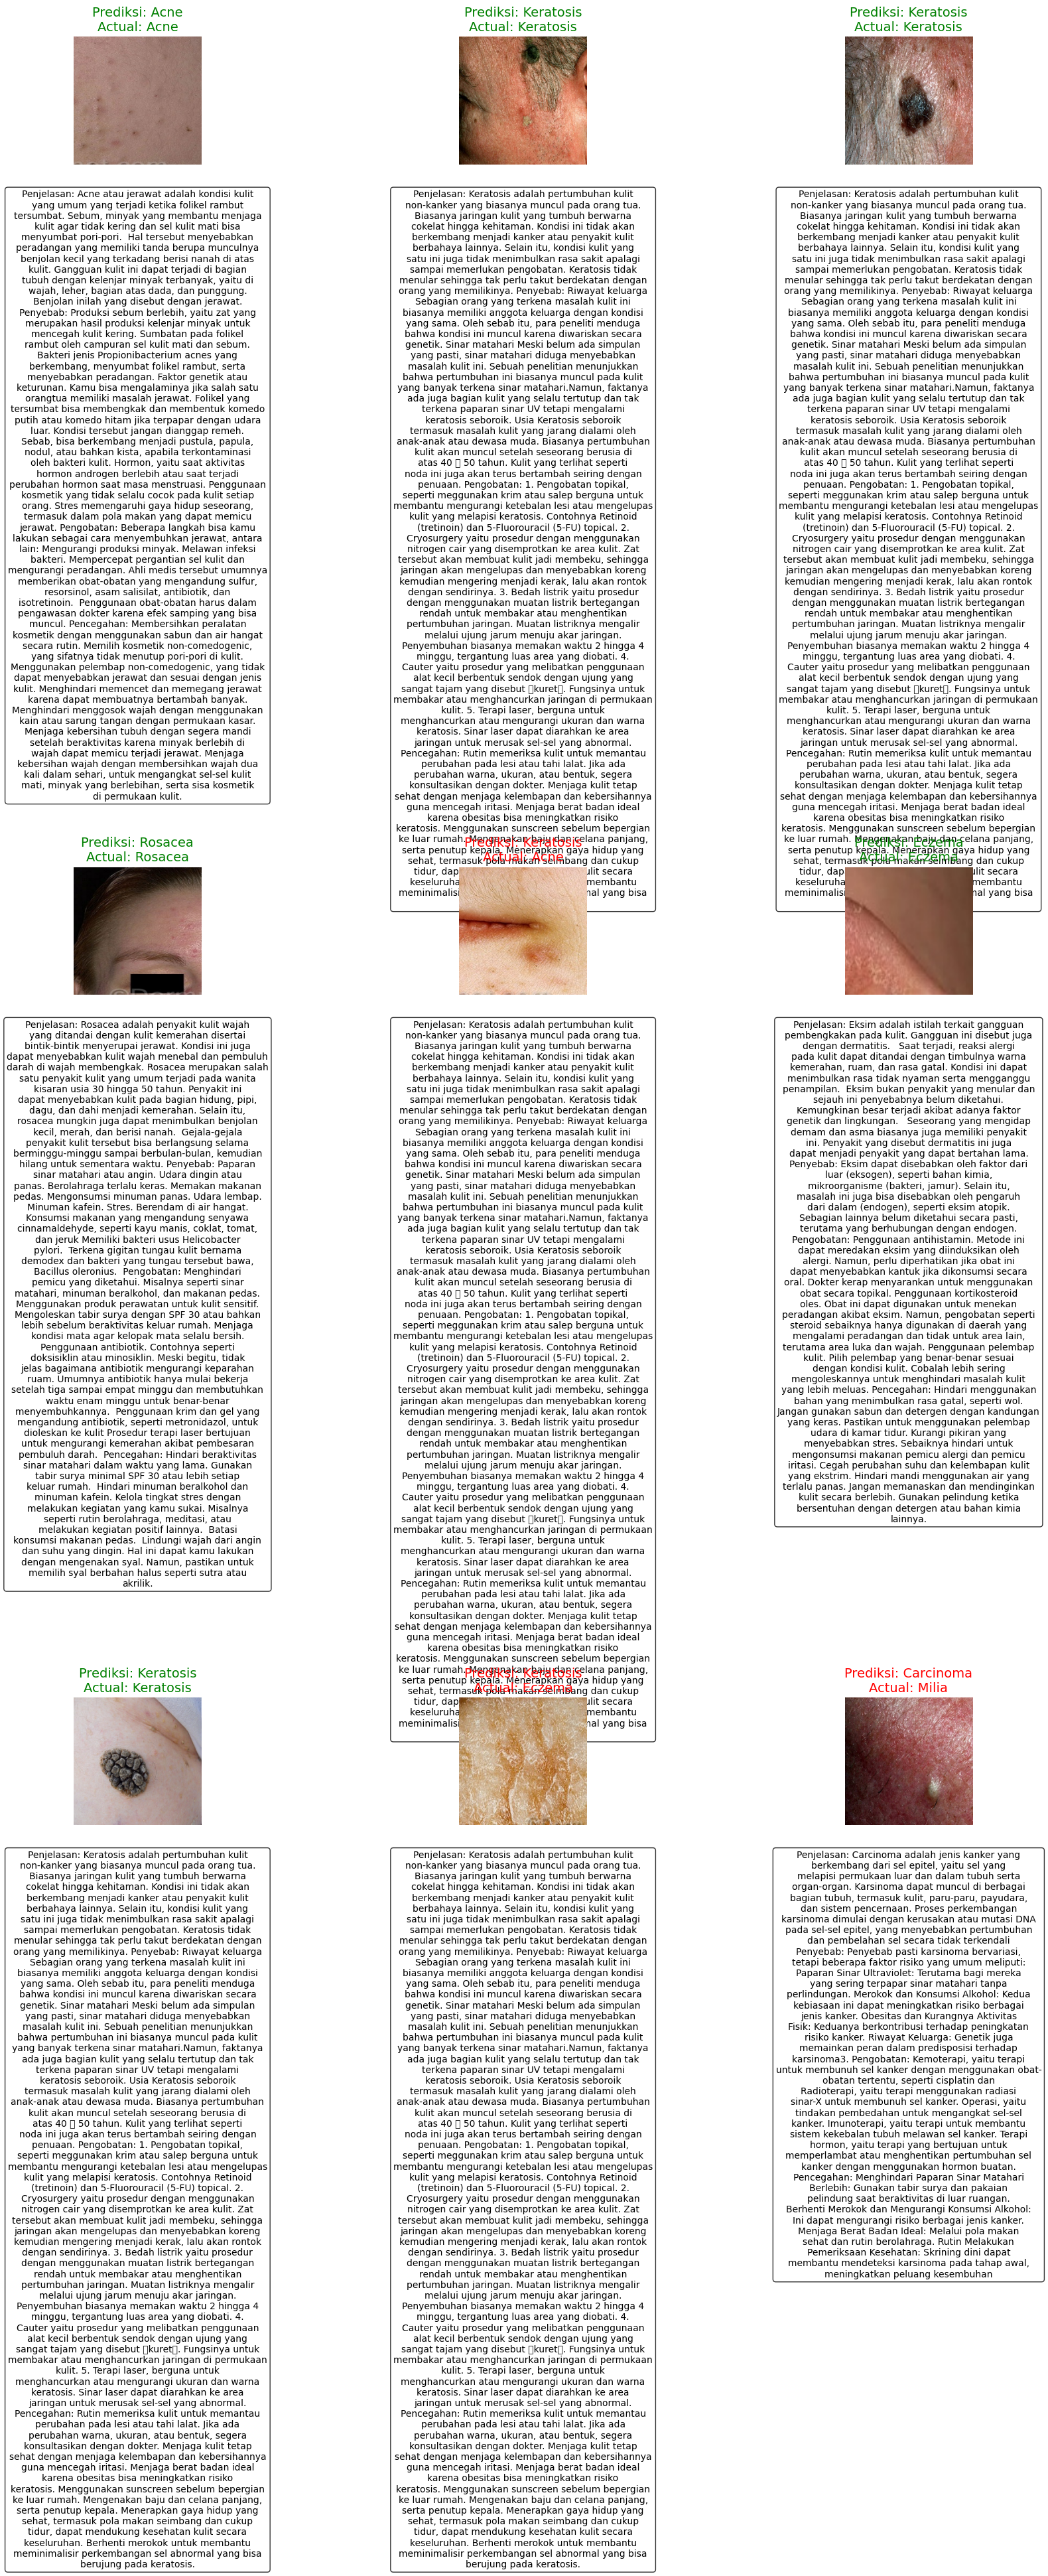

In [21]:
# Pastikan label kelas sesuai
class_names = ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']  # Sesuaikan dengan dataset Anda

# Plot hasil dengan informasi deskripsi lengkap
plot_random_images_with_full_info(test_dataset, model, class_names, disease_info, num_images=9)


### **Menyimpan Model (jangan di run kalau belum jadi modelnnya)**

In [ ]:
# Save the model as .h5
model.save('cnn_model.h5')
print("Model saved as cnn_model.h5")

Model saved as cnn_model.h5
